# Environmental Performance Index for Countries
This project is drawn from and inspired by Professor Umerberto Mignozzetti's Machine Learning for Political Scientists course at UCSD (POLI 176). 

I will be using 2019 environmental indicators from the [QOG Environmental Indicators Codebook]("https://www.qogdata.pol.gu.se/data/codebook_ei_sept21.pdf") to construct a cumulative environmental performance index score, which can be used to analyze a country's commitment to setting effective environmental policies and changes. 

The indicators I will be working with measure how well countries adhere to internationally established environmental target areas from argriculture and biodiversity to methane growth rate. 



ways to expand: 
- epi values relationship with environmenal values from dataset and gdp, relationship between gdp and environmental values


In [1]:
# Loading packages

#Pandas and Numpy
import pandas as pd
#pd.set_option('mode.chained_assignment', None)
import numpy as np

# Matplotlib and seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Embedding, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

2023-04-12 19:41:54.776953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Constructing an Environmental Performance Index Score using PCA 
I will be using Principle Component Analysis (PCA) to create a cumulative Environmental Performance Index (`epi`) score because PCA can reduce the dimensionality of the 33 variables (`epivars`) into just one score for better analysis. It can also help us understand which features explain most of the variance in epi. 


In [2]:
# Preparing the data
epivars = ['epi_tbn', 'epi_tbg', 'epi_ghp', 'epi_uwd', 'epi_usd', 'epi_pmd', 
           'epi_bhv', 'epi_pbd', 'epi_par', 'epi_ozd', 'epi_msw', 'epi_had', 
           'epi_wwt', 'epi_snm', 'epi_gib', 'epi_cha', 'epi_cda', 'epi_noa', 
           'epi_bca', 'epi_sda', 'epi_nxa', 'epi_wrs', 'epi_wmg', 'epi_agr', 
           'epi_air', 'epi_ape', 'epi_bdh', 'epi_cch', 'epi_hmt', 'epi_eh', 
           'epi_h2o', 'epi_ev', 'epi_tcl']

#envind = pd.read_csv('https://www.qogdata.pol.gu.se/data/qog_ei_sept21.csv', encoding='ISO-8859-1')
envind = pd.read_csv("qog_ei_sept21.csv")
envind = envind[envind.year == 2019]
envind = envind[['cname', 'ccodealp'] + epivars]
envind = envind.dropna().reset_index(drop = True)
envind.head()

,cname,ccodealp,epi_tbn,epi_tbg,epi_ghp,epi_uwd,epi_usd,epi_pmd,epi_bhv,epi_pbd,...,epi_agr,epi_air,epi_ape,epi_bdh,epi_cch,epi_hmt,epi_eh,epi_h2o,epi_ev,epi_tcl
0,Afghanistan,AFG,0.613935,1.343170,100.000000,27.700187,28.453538,25.353188,57.6619,0.000000,...,51.0,17.7,0.0,21.9,22.2,0.0,20.0,28.0,29.2,95.026484
1,Albania,ALB,100.000000,100.000000,58.277657,50.192252,59.655450,44.207264,39.6498,46.091071,...,37.6,41.2,100.0,68.2,56.8,46.1,44.5,54.0,52.0,41.131526
2,Algeria,DZA,43.203333,45.913945,44.551134,48.981206,59.583556,21.882785,75.3868,38.876502,...,44.8,45.3,61.7,39.0,52.5,38.9,50.4,53.2,41.0,17.253658
3,Angola,AGO,34.107313,36.584598,60.292819,11.857848,14.103985,32.646545,67.2435,37.259598,...,29.3,26.8,2.6,39.3,49.0,37.3,20.4,12.8,35.9,31.151582
4,Antigua and Barbuda,ATG,90.265580,87.301849,35.217347,45.018148,57.477222,44.622843,33.9933,60.530070,...,5.1,57.5,36.6,55.7,58.5,60.5,55.5,50.0,43.8,35.385790


In [3]:
#dropping country names to scale variables
envind_dropnames = envind.drop(columns = ['cname', 'ccodealp'])
envind_dropnames.head()

,epi_tbn,epi_tbg,epi_ghp,epi_uwd,epi_usd,epi_pmd,epi_bhv,epi_pbd,epi_par,epi_ozd,...,epi_agr,epi_air,epi_ape,epi_bdh,epi_cch,epi_hmt,epi_eh,epi_h2o,epi_ev,epi_tcl
0,0.613935,1.343170,100.000000,27.700187,28.453538,25.353188,57.6619,0.000000,5.016289,16.865792,...,51.0,17.7,0.0,21.9,22.2,0.0,20.0,28.0,29.2,95.026484
1,100.000000,100.000000,58.277657,50.192252,59.655450,44.207264,39.6498,46.091071,38.643220,60.146800,...,37.6,41.2,100.0,68.2,56.8,46.1,44.5,54.0,52.0,41.131526
2,43.203333,45.913945,44.551134,48.981206,59.583556,21.882785,75.3868,38.876502,7.073943,33.245300,...,44.8,45.3,61.7,39.0,52.5,38.9,50.4,53.2,41.0,17.253658
3,34.107313,36.584598,60.292819,11.857848,14.103985,32.646545,67.2435,37.259598,29.836838,34.420066,...,29.3,26.8,2.6,39.3,49.0,37.3,20.4,12.8,35.9,31.151582
4,90.265580,87.301849,35.217347,45.018148,57.477222,44.622843,33.9933,60.530070,53.752028,100.000000,...,5.1,57.5,36.6,55.7,58.5,60.5,55.5,50.0,43.8,35.385790


In [4]:
#fit PCA model 
model = PCA()
model.fit(envind_dropnames)
envind_pca = model.transform(envind_dropnames)

#standardizing the result
scaler = StandardScaler()
epi_vars = scaler.fit_transform(envind_pca)

#creating the epi column 
epi = epi_vars[:,0]
envind['epi'] = epi

#standardized epi column 
envind['epi']

0     -1.594564
1      0.068772
2      0.374406
3     -1.219780
4      0.179660
         ...   
163   -1.020193
164    0.153323
165   -0.485700
166   -0.157866
167   -1.017232
Name: epi, Length: 168, dtype: float64

### Exploring the `epi` Score
After sorting the scores, observationally, these country groupings make sense. In general, the countries with higher `epi` scores are known to be more environmentally conscious. The countries with lower `epi` scores, in general, face more internal struggles that may make it difficult to promote more environmental policies. 

In [5]:
envind.sort_values('epi', ascending=False).head()

,cname,ccodealp,epi_tbn,epi_tbg,epi_ghp,epi_uwd,epi_usd,epi_pmd,epi_bhv,epi_pbd,...,epi_air,epi_ape,epi_bdh,epi_cch,epi_hmt,epi_eh,epi_h2o,epi_ev,epi_tcl,epi
45,Denmark,DNK,85.949602,85.949602,31.804831,95.659570,100.00000,78.773053,44.4610,100.000000,...,85.5,100.0,81.7,95.0,100.0,91.7,97.4,76.4,26.162972,2.161369
160,United Kingdom of Great Britain and Northern I...,GBR,98.363463,97.901287,35.087965,100.000000,100.00000,75.439245,44.7058,94.555263,...,84.7,100.0,88.0,90.0,94.6,91.7,100.0,74.3,24.018449,2.112620
91,Luxembourg,LUX,100.000000,100.000000,7.310877,97.660423,100.00000,81.385329,48.4668,96.072911,...,87.2,100.0,85.5,77.5,96.1,92.6,98.6,75.4,30.680705,2.106325
147,Sweden,SWE,61.566109,63.639766,37.035410,97.706227,99.67711,100.000000,71.5837,97.964677,...,98.2,100.0,72.5,77.2,98.0,98.4,98.5,65.6,19.837081,2.096671
55,Finland,FIN,72.759480,72.814244,18.735962,100.000000,100.00000,100.000000,75.7991,100.000000,...,98.8,93.1,75.5,77.0,100.0,99.3,100.0,65.3,18.424769,2.062642


In [6]:
envind.sort_values('epi', ascending=False).tail()

,cname,ccodealp,epi_tbn,epi_tbg,epi_ghp,epi_uwd,epi_usd,epi_pmd,epi_bhv,epi_pbd,...,epi_air,epi_ape,epi_bdh,epi_cch,epi_hmt,epi_eh,epi_h2o,epi_ev,epi_tcl,epi
3,Angola,AGO,34.107313,36.584598,60.292819,11.857848,14.103985,32.646545,67.2435,37.259598,...,26.8,2.6,39.3,49.0,37.3,20.4,12.8,35.9,31.151582,-1.219780
67,Haiti,HTI,38.348225,53.652489,86.399967,13.783777,14.391166,47.487494,40.9772,12.088787,...,31.1,23.8,34.5,37.0,12.1,21.8,14.0,30.5,22.797293,-1.238480
89,Liberia,LBR,21.319531,55.744578,100.000000,9.417096,10.477379,43.749916,57.2193,37.269751,...,30.9,32.7,32.6,24.9,37.3,21.3,9.8,23.6,11.188625,-1.276713
112,Niger,NER,85.538754,83.939722,81.887299,1.558406,1.286959,48.573056,73.7857,27.287264,...,30.3,0.9,77.6,12.5,27.3,17.1,1.4,39.9,100.000000,-1.493133
0,Afghanistan,AFG,0.613935,1.343170,100.000000,27.700187,28.453538,25.353188,57.6619,0.000000,...,17.7,0.0,21.9,22.2,0.0,20.0,28.0,29.2,95.026484,-1.594564


### Plotting `epi`
After plotting the variance of the features, seems like the first component explains much of the variance in the data. We can plot the weights of the first component to see if there are variables that are more influencial. 

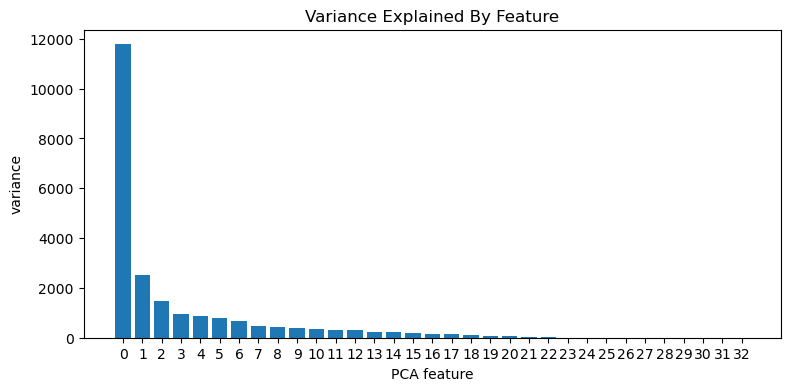

In [7]:
# Plotting Variance of Features 
features = range(model.n_components_)
plt.figure(figsize=(9, 4))
plt.bar(features, model.explained_variance_)
plt.title("Variance Explained By Feature")
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

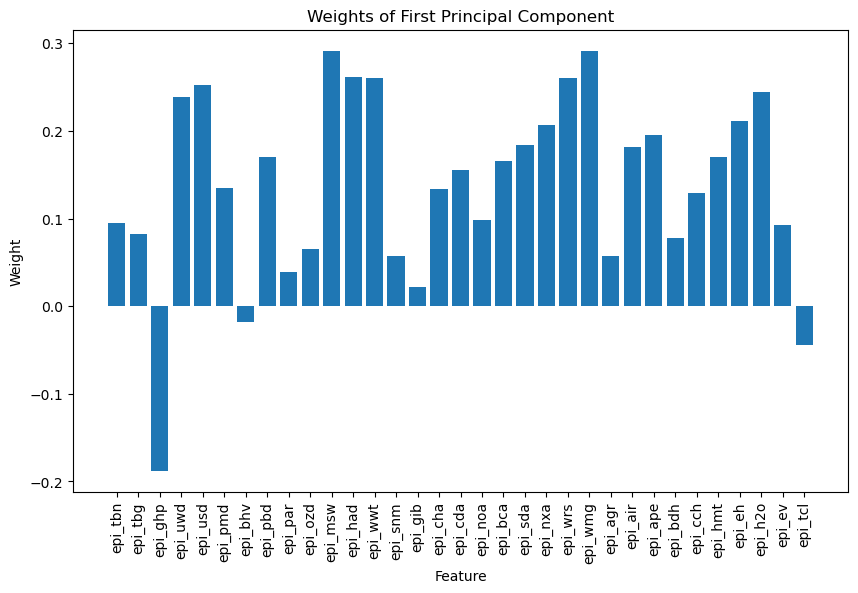

In [8]:
# Weights of first components
weights = model.components_[0]

# Feature names
feature_names = envind.columns[2:-1]

# Plotting Weights
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(feature_names, weights)
ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
ax.set_title('Weights of First Principal Component')
plt.xticks(rotation=90)
plt.show()

From the graph, we can see that `epi_ghp` has greater negative effect than all other features. `epi_ghp` measures greenhouse gas emissions per capita, so it makes sense that higher measures of this variables is related to lower `epi` scores. 
The two highest features are `epi_msw` (controlled solid waste) and `epi_wmg` (waste management issue) though not by a significant amount. 

These feature reveal insight on what areas can be targeted for future policies. 

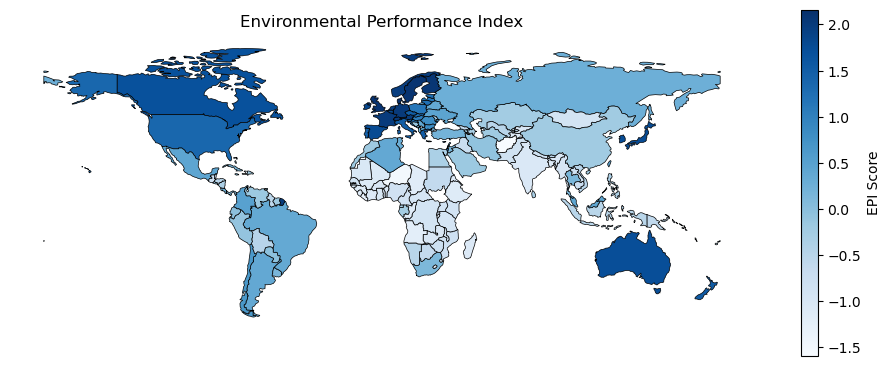

In [58]:
# Loading shapefile for country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge world dataset with envind 
world = world.merge(envind, left_on='iso_a3', right_on='ccodealp')

# Create a heatmap of epi scores across countries 
fig, ax = plt.subplots(figsize=(12, 9))
world.plot(column='epi', cmap='Blues', linewidth=0.5, edgecolor='black', 
           legend=True, legend_kwds={'label': "EPI Score", "shrink":0.5}, ax=ax)
ax.axis('off')
ax.set_title('Environmental Performance Index')
plt.show()